<a href="https://colab.research.google.com/github/mferiansyahrt/increasing_synth_image/blob/main/Testing/SISR_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEFINE FUNCTION

In [ ]:
!pip install tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D,Multiply
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU,PReLU,UpSampling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Concatenate, Flatten, Reshape, Lambda, Dense
from tensorflow.keras.layers import LayerNormalization, Add, GaussianNoise
from tensorflow.keras.activations import gelu

from os import listdir
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.utils import resample

from datetime import datetime
from tensorflow.keras.models import load_model
import tensorflow as tf
import cv2

from matplotlib import pyplot
import numpy as np
import shutil
from PIL import Image

# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim
from skimage import io, color

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
!git clone https://www.github.com/keras-team/keras-contrib.git

#Download instance norm. code from the link above.
#Or install keras_contrib using guidelines here: https://github.com/keras-team/keras-contrib
#from instancenormalization import InstanceNormalization
%cd keras-contrib
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

Cloning into 'keras-contrib'...
remote: Enumerating objects: 3634, done.
remote: Total 3634 (delta 0), reused 0 (delta 0), pack-reused 3634 (from 1)
Receiving objects: 100% (3634/3634), 861.24 KiB | 5.98 MiB/s, done.
Resolving deltas: 100% (2330/2330), done.
/content/keras-contrib


In [ ]:
# discriminator model (70x70 patchGAN)
# C64-C128-C256-C512
#After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.
# The “axis” argument is set to -1 for instance norm. to ensure that features are normalized per feature map.
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	#d = GroupNormalization(groups = -1, axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	#d = GroupNormalization(groups = -1, axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	#d = GroupNormalization(groups = -1, axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	#d = GroupNormalization(groups = -1, axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt.
    #with a small learning rate and 0.5 beta.
    #The loss for the discriminator is weighted by 50% for each model update.
    #This slows down changes to the discriminator relative to the generator model during training.
	model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=0.5)
	return model

In [ ]:
# generator a resnet block to be used in the generator
# residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layers.
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# define the  generator model - encoder-decoder type architecture

#c7s1-k denote a 7×7 Convolution-InstanceNorm-ReLU layer with k filters and stride 1.
#dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2.
# Rk denotes a residual block that contains two 3 × 3 convolutional layers
# uk denotes a 3 × 3 fractional-strided-Convolution InstanceNorm-ReLU layer with k filters and stride 1/2

#The network with 6 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3

#The network with 9 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128, u64,c7s1-3

def define_generator(image_shape, n_resnet=10):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	#g = GroupNormalization(groups = -1, axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
#We define a composite model that will be used to train each generator separately.
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# Make the generator of interest trainable as we will be updating these weights.
    #by keeping other models constant.
    #Remember that we use this same function to train both generators,
    #one generator at a time.
	g_model_1.trainable = True
	# mark discriminator and second generator as non-trainable
	d_model.trainable = False
	g_model_2.trainable = False

	# adversarial loss
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity loss
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# cycle loss - forward
	output_f = g_model_2(gen1_out)
	# cycle loss - backward
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)

	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

  # define the optimizer
	opt = Adam(learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.999, epsilon = 1e-8)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'],
               loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [ ]:
def composite_sr_model(g_model_1,g_model_2,sr_model,image_shape,hr_shape):
  g_model_1.trainable = False
  g_model_2.trainable = False

  # pseudo domain
  #input_clr = Input(shape=image_shape)
  input_real_hr = Input(shape=hr_shape)
  #image_shape = tf.constant([image_shape[0], image_shape[1]])
  clr_image = Lambda(lambda image: tf.image.resize(image, image_shape[0:2]))(input_real_hr)
  gen1_out_clr = g_model_1(clr_image) #clr to lr
  gen2_out_clr = g_model_2(gen1_out_clr) #pseudo clr
  sr_pseudo_clr = sr_model(gen2_out_clr)

  # LR domain
  input_real_lr = Input(shape=image_shape)
  gen1_out_lr = g_model_2(input_real_lr) #lr to clr
  sr_lr = sr_model(gen1_out_lr)

  model = Model([input_real_hr,input_real_lr],[sr_pseudo_clr,sr_lr])
  # define the optimizer
  opt = Adam(learning_rate=0.0001, beta_1 = 0.9, epsilon = 1e-8)
  # compile model with weighting of least squares loss and L1 loss
  model.compile(loss=['mae', 'mae'],
                loss_weights=[1, 5], optimizer=opt)
  return model

# CREATE DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir /content/day2night/
%cd /content/day2night/
#!unzip /content/gdrive/MyDrive/day2night_bdd_ip2.zip # Dataset campuran yang baru
!unzip /content/gdrive/MyDrive/day2night_bdd_ip.zip # Dataset campuran yang lama
#!unzip /content/gdrive/MyDrive/day2night.zip # Dataset asli

/content/day2night
Archive:  /content/gdrive/MyDrive/day2night_bdd_ip.zip
   creating: trainDay/
  inflating: trainDay/6a729de1-7adc57f8.jpg  
  inflating: __MACOSX/trainDay/._6a729de1-7adc57f8.jpg  
  inflating: trainDay/Image_15.jpg   
  inflating: trainDay/Image_29.jpg   
  inflating: trainDay/1c1de1e7-346d6219.jpg  
  inflating: __MACOSX/trainDay/._1c1de1e7-346d6219.jpg  
  inflating: trainDay/6ad23488-70abed67.jpg  
  inflating: __MACOSX/trainDay/._6ad23488-70abed67.jpg  
  inflating: trainDay/6a626ee3-61100bbc.jpg  
  inflating: __MACOSX/trainDay/._6a626ee3-61100bbc.jpg  
  inflating: trainDay/0f145ef9-2fb016d0.jpg  
  inflating: __MACOSX/trainDay/._0f145ef9-2fb016d0.jpg  
  inflating: trainDay/00f7eac8-5193d600.jpg  
  inflating: __MACOSX/trainDay/._00f7eac8-5193d600.jpg  
  inflating: trainDay/Image_28.jpg   
  inflating: trainDay/Image_14.jpg   
  inflating: trainDay/1a2f2112-f566a272.jpg  
  inflating: __MACOSX/trainDay/._1a2f2112-f566a272.jpg  
  inflating: trainDay/0a0c3694

In [ ]:
import os

os.remove('/content/day2night/trainDay/.DS_Store')
os.remove('/content/day2night/trainNight/.DS_Store')

day = sorted(os.listdir('/content/day2night/trainDay/'))
night = sorted(os.listdir('/content/day2night/trainNight/'))

In [ ]:
# bdd_day2night

# load all images in a directory into memory
def load_images(path, size=(512,512)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

# dataset path
path_HR = '/content/day2night/'

# load dataset night HIGH RESOLUTION (HR) -- TARGET
dataHR_all = load_images(path_HR + 'trainNight/')
print('Loaded dataHR: ', dataHR_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management.
dataHR = resample(dataHR_all,
                 replace=False,
                 n_samples=len(night),
                 random_state=42)
print(f'Use Real Night HR Images(dataHR) with total of {dataHR.shape[0]} images for training')

# load dataset night LOW RESOLUTION (LR) -- FEATURE
path_lr = '/content/gdrive/MyDrive/night_generated_uvcgan/'
dataLR_all = load_images(path_lr + 'night/', size=(256,256))
print('Loaded dataLR: ', dataLR_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management.
dataLR = resample(dataLR_all,
                 replace=False,
                 n_samples=len(night),
                 random_state=42)
print(f'Use Synthetic Night Generated LR Images (dataLR) with total of {dataLR.shape[0]} images for training')

Loaded dataHR:  (169, 512, 512, 3)
Use Real Night HR Images(dataHR) with total of 169 images for training
Loaded dataLR:  (169, 256, 256, 3)
Use Synthetic Night Generated LR Images (dataLR) with total of 169 images for training


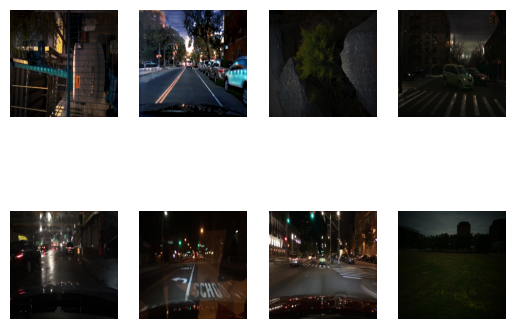

Loaded (169, 256, 256, 3) (169, 512, 512, 3)


In [ ]:
# plot source images
n_samples = 4
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataLR[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataHR[i].astype('uint8'))
plt.show()

# load image data
data = [dataLR, dataHR]

print('Loaded', data[0].shape, data[1].shape)

#Preprocess data to change input range to values between -1 and 1
# This is because the generator uses tanh activation in the output layer
#And tanh ranges between -1 and 1
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

def preprocess_data_input_edge(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [0,1]
	X1 = (X1) / 255.0
	X2 = (X2) / 255.0
	return [X1, X2]

dataset_synthetic2real = preprocess_data(data)

In [ ]:
# bdd_day2night

# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

# dataset path
path = '/content/day2night/'

# load dataset A - day
dataA_all = load_images(path + 'trainDay/')
print('Loaded dataA: ', dataA_all.shape)

#To get a subset of all images, for faster training during demonstration
dataA = resample(dataA_all,
                 replace=False,
                 n_samples=len(day),
                 random_state=42)
print(f'Use Day Images (dataA) with total of {dataA.shape[0]} images for training')

# load dataset B - night
dataB_all = load_images(path + 'trainNight/', size=(512,512))
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management.
dataB = resample(dataB_all,
                 replace=False,
                 n_samples=len(night),
                 random_state=42)
print(f'Use Night Images (dataB) with total of {dataB.shape[0]} images for training')

Loaded dataA:  (169, 256, 256, 3)
Use Day Images (dataA) with total of 169 images for training
Loaded dataB:  (169, 512, 512, 3)
Use Night Images (dataB) with total of 169 images for training


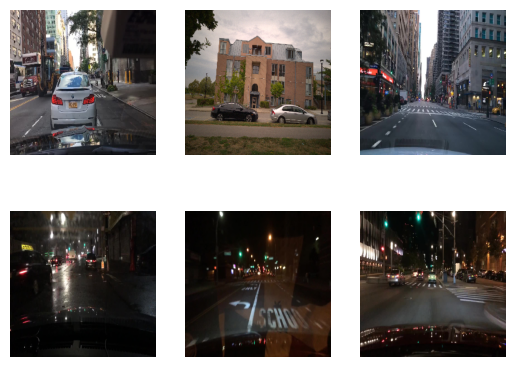

Loaded (169, 256, 256, 3) (169, 512, 512, 3)


In [ ]:
# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
plt.show()

# load image data
data = [dataA, dataB]

print('Loaded', data[0].shape, data[1].shape)

#Preprocess data to change input range to values between -1 and 1
# This is because the generator uses tanh activation in the output layer
#And tanh ranges between -1 and 1
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

def preprocess_data_input_edge(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [0,1]
	X1 = (X1) / 255.0
	X2 = (X2) / 255.0
	return [X1, X2]

dataset_day2night = preprocess_data(data)

# ESRGAN+

In [ ]:
def residual_dense_block(x):
  x1 = Conv2D(64,(3,3),padding = 'same')(x)
  x1 = LeakyReLU(0.2)(x1)
  x1c = Concatenate()([x,x1])

  x2 = Conv2D(64,(3,3),padding = 'same')(x1c)
  x2 = LeakyReLU(0.2)(x2)
  x2c_conc = Concatenate()([x,x1c,x2]) # disini fiturnya menjadi 256
  x2c_upfeat = Conv2D(x2c_conc.shape[-1],(3,3),padding = 'same')(x)
  x2c = Add()([x2c_upfeat,x2c_conc])

  x3 = Conv2D(64,(3,3),padding = 'same')(x2c)
  x3 = LeakyReLU(0.2)(x3)
  x3c = Concatenate()([x,x1c,x2c,x3])

  x4 = Conv2D(64,(3,3),padding = 'same')(x3c)
  x4 = LeakyReLU(0.2)(x4)
  x4c_conc = Concatenate()([x,x1c,x2c,x4]) # disini fiturnya menjadi 512
  x4c_upfeat = Conv2D(x4c_conc.shape[-1],(3,3),padding = 'same')(x2c)
  x4c = Add()([x4c_upfeat,x4c_conc])

  xo = Conv2D(64,(3,3),padding = 'same')(x4c)

  return xo

def rrdrb(x,beta,gamma,stddev):
  x_gauss = Lambda(lambda x: tf.random.normal(shape = tf.shape(x), mean = 0.0, stddev = stddev))(x)
  x_gauss = Lambda(lambda x: x * gamma)(x_gauss)

  x_rrdb1 = residual_dense_block(x)
  x_rrdb1 = Lambda(lambda x: x * beta)(x_rrdb1)
  x_rrdb1 = Add()([x,x_rrdb1])
  x_rrdb1 = Add()([x_rrdb1,x_gauss])

  x_rrdb2 = residual_dense_block(x_rrdb1)
  x_rrdb2 = Lambda(lambda x: x * beta)(x_rrdb2)
  x_rrdb2 = Add()([x_rrdb1,x_rrdb2])
  x_rrdb2 = Add()([x_rrdb2,x_gauss])

  x_rrdb3 = residual_dense_block(x_rrdb2)
  x_rrdb3 = Lambda(lambda x: x * beta)(x_rrdb3)
  x_rrdb3 = Add()([x_rrdb2,x_rrdb3])
  x_rrdb3 = Add()([x_rrdb3,x_gauss])

  x_rrdb3 = Lambda(lambda x: x * beta)(x_rrdb3)
  x_rrdb = Add()([x,x_rrdb3])

  return x_rrdb

def upscale_block(x,factor):

  up_model = Conv2D(256, (3,3), padding="same")(x)
  up_model = UpSampling2D( size = factor )(up_model)
  up_model = PReLU(shared_axes=[1,2])(up_model)

  return up_model

def up_sampling_sr(layer, numfilter):
  l = Conv2DTranspose(numfilter, (3,3), strides = 2, padding = 'same')(layer)
  l = PReLU(shared_axes=[1,2])(l)
  return l

In [ ]:
# gunakan fungsi ini ketika tidak mengcompile, fungsi ini berkaitan dengan train saja
def super_resolution(input_shape,target_shape,num_rrdrb,beta,gamma,stddev):
  #Define enlightenGAN, ESRGAN, dan ESRGAN+ disini

  i = Input(shape = input_shape)
  x = Conv2D(64,(9,9),padding = 'same')(i)
  x = Activation('leaky_relu')(x)
  temp = x

  for j in range(num_rrdrb):
    x = rrdrb(x,beta,gamma,stddev)

  x = Conv2D(64,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)
  x = Add()([x,temp])

  x = upscale_block(x,target_shape)
  #x = upscale_block(x,target_shape)

  x = Conv2D(64,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)
  x = Conv2D(3, (7,7), padding='same')(x)
  out_image = Activation('tanh')(x)

  sr_model = Model(i,x)
  #sr_model.compile(loss='mae', optimizer=Adam(learning_rate=0.0002, beta_1=0.9), loss_weights=0.01)
  return sr_model

# gunakan fungsi ini ketika ingin mengcompile, fungsi ini berkaitan dengan train2
def super_resolution2(input_shape,target_shape,num_rrdrb,beta,gamma,stddev):
  #Define enlightenGAN, ESRGAN, dan ESRGAN+ disini

  i = Input(shape = input_shape)
  x = Conv2D(64,(9,9),padding = 'same')(i)
  x = Activation('leaky_relu')(x)
  temp = x

  for j in range(num_rrdrb):
    x = rrdrb(x,beta,gamma,stddev)

  x = Conv2D(64,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)
  x = Add()([x,temp])

  x = upscale_block(x,target_shape)
  #x = upscale_block(x,target_shape)

  x = Conv2D(64,(3,3),padding = 'same')(x)
  x = Activation('leaky_relu')(x)
  x = Conv2D(3, (7,7), padding='same')(x)
  out_image = Activation('tanh')(x)

  sr_model = Model(i,x)
  sr_model.compile(loss='mae', optimizer=Adam(learning_rate=0.0002, beta_1=0.9), loss_weights=10)
  # sr_model.compile(loss=contextual_bilateral_loss, optimizer=Adam(learning_rate=0.0002, beta_1=0.9))
  return sr_model

# CREATE DATA TEST for visualization (day2night)



In [ ]:
main_path = '/content/day2night/trainDay/'
test_path = ['0ab72d5d-af77406b.jpg','0c1eebb0-dbb11761.jpg','0f9fbe4b-081bb395.jpg','0fc07ccd-14991933.jpg','Image_35.jpg','Image_9.jpg']

In [ ]:
# load all images in a directory into memory
def load_images_test(path, test_im, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in test_im:
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

def preprocess_data_test(data):
	# load compressed arrays
	# unpack arrays
	# scale from [0,255] to [-1,1]
	X1 = (data - 127.5) / 127.5
	return X1

In [ ]:
# load dataset A - day
data_test = load_images_test(main_path, test_path)
print('Loaded data test: ', data_test.shape)

Loaded data test:  (6, 256, 256, 3)


In [ ]:
preprocesed_data_test = preprocess_data_test(data_test)

# CREATE DATA TEST

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

!mkdir /content/sample_data/bdd_data
%cd /content/sample_data/bdd_data
!unzip /content/gdrive/MyDrive/bdd2k.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/train/images/._7c0a7d5a-da928c23.jpg  
  inflating: train/images/a1b11f0e-3e9402a2.jpg  
  inflating: __MACOSX/train/images/._a1b11f0e-3e9402a2.jpg  
  inflating: train/images/31081723-b51998d4.jpg  
  inflating: __MACOSX/train/images/._31081723-b51998d4.jpg  
  inflating: train/images/12dbce83-368f9b4c.jpg  
  inflating: __MACOSX/train/images/._12dbce83-368f9b4c.jpg  
  inflating: train/images/3516379e-43f6a6ba.jpg  
  inflating: __MACOSX/train/images/._3516379e-43f6a6ba.jpg  
  inflating: train/images/66808c3c-04f3a0d5.jpg  
  inflating: __MACOSX/train/images/._66808c3c-04f3a0d5.jpg  
  inflating: train/images/00d79c0a-23bea078.jpg  
  inflating: __MACOSX/train/images/._00d79c0a-23bea078.jpg  
  inflating: train/images/57e171f1-00d42305.jpg  
  inflating: __MACOSX/train/images/._57e171f1-00d42305.jpg  
  inflating: train/images/955e0d15-eaf92849.jpg  
  inflating: __MACOSX/train/images/._955e0d15-eaf92849.jpg  


In [ ]:
import os

p_t = '/content/sample_data/bdd_data/train/labels/'
p_v = '/content/sample_data/bdd_data/val/labels/'

os.remove(p_t + '.DS_Store')
os.remove(p_v + '.DS_Store')

In [ ]:
list_night_image = ['0096bcca-c2027ec4.jpg','012a9c41-edad898c.jpg','013ae324-36be6bc2.jpg','03343856-ebf78b5f.jpg',
                    '075d2e1d-971a3fea.jpg','087f969b-b1584c3f.jpg','098ea6fe-b67e6fbb.jpg','0b2867ef-a6ca437b.jpg',
                    '0bb001f6-80239764.jpg','0cf398b3-ce65ab64.jpg','0d933eed-b74c36f8.jpg','0e764680-656be9ac.jpg',
                    '0fe831f2-d3180400.jpg','1041f776-fcce9b98.jpg','11bfabe9-64e974b5.jpg','13620abf-62b6685f.jpg',
                    '14fc6ba0-f47c2960.jpg','196d16dd-e26c2301.jpg','1a3e80fd-9bfaf43b.jpg','1aa6dd36-8feb5194.jpg',
                    '1b883059-144b2678.jpg','1beed53f-d02fafd3.jpg','1bf6d50e-48ea2889.jpg','1c3bf90b-f605473c.jpg',
                    '205c57a8-74c6f50b.jpg','26afd0b9-d88e35cb.jpg','280855ec-e506e694.jpg','2a051b12-a7404163.jpg',
                    '2b923350-d824c179.jpg','2bcdafa3-0013d653.jpg','2e3e8698-72305bda.jpg','2f1b8110-37e9fbad.jpg',
                    '300e816b-f221ac28.jpg','3335e32b-d9fab7f9.jpg','34811fce-1c9200fe.jpg','34bd8b4d-00530890.jpg',
                    '35550c7a-168d1f0e.jpg','366fca59-3696cc7d.jpg','378465c1-894b1418.jpg','38a71b3e-def4acdd.jpg',
                    '3b59c8a5-f0b031cc.jpg','3d3117f0-9365aac0.jpg','3eb86f80-6bb67f5c.jpg','3eec0a14-ab3e67db.jpg',
                    '4283e5c3-5cf933f4.jpg','44babb70-10b348cc.jpg','44d5e383-c58840d5.jpg','453569ca-49948b65.jpg',
                    '465eada1-87de6436.jpg','4899be53-dcc6c017.jpg','4b9fbba7-eb44510f.jpg','4cd5c4d3-935c6463.jpg',
                    '511c0871-7d84ede2.jpg','567b4b61-fd213940.jpg','597f3962-670ad442.jpg','5a1ed081-8b80a48f.jpg',
                    '5b7f03ae-45fe20ac.jpg','5c1e4531-d8ce5e7b.jpg','5c662be9-442b30ef.jpg','5ca490b4-ef154db0.jpg',
                    '5e09670a-515153fd.jpg','5ff99bb6-d7e354c2.jpg','616a276c-c76f9016.jpg','631973a4-ed1655d9.jpg',
                    '64be001d-d9d6743e.jpg','652bcde6-e5b65ebb.jpg','661a6487-0fe5a381.jpg','66269058-5f039fdb.jpg',
                    '67c0f623-67cefe4e.jpg','684715d5-23039d9c.jpg','6bc3cef7-14c3b0b7.jpg','6dcbd3f4-3a4d0439.jpg',
                    '700c3115-5b5b7652.jpg','718c55f5-65f193ec.jpg','738df342-eec9a6d4.jpg','7abfb361-ad1b41e8.jpg',
                    '7f8dc184-1d22a39b.jpg','7fd98fe2-f8290610.jpg','857bf9bc-a83d4e67.jpg','86340950-d91b4146.jpg',
                    '8ee48b61-a9ab1674.jpg','92399a77-e2155d46.jpg','93260910-96c238d9.jpg','932ab3d2-0ef6d829.jpg',
                    '96929662-36778607.jpg','96ced888-e319b06f.jpg','9724d02c-d0e2ba12.jpg','9aae6ee4-72a0a5a8.jpg',
                    'a11b0da5-014d5c45.jpg','a12d8ff4-c8c0b1fc.jpg','a1a8db6b-f5d2991f.jpg','a1c31e7f-148b2fca.jpg',
                    'a279854d-162bd02c.jpg','a310e8f3-65a5066d.jpg','a37192a8-b04db02d.jpg','a7b8aa00-80f77761.jpg',
                    'a93af51d-96dae531.jpg','ab54b6e9-91a74408.jpg','ac986974-93ee1b97.jpg','ad73ec70-c8312a27.jpg',
                    'af0f7447-c370bcc7.jpg','b18ff6ee-eed61648.jpg']

In [ ]:
len(os.listdir('/content/sample_data/bdd_data/train/images/'))

2081

In [ ]:
train_image_path = '/content/day2night/trainDay/'
parent_path = '/content/sample_data/bdd_data/train/images/'

for im in os.listdir(train_image_path):
  if im in os.listdir(parent_path):
    os.remove(parent_path + im)

In [ ]:
for im_night in list_night_image:
  if im_night in os.listdir(parent_path):
    os.remove(parent_path + im_night)

In [ ]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

data_test = load_images('/content/sample_data/bdd_data/train/images/')

In [ ]:
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1 = data
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	return X1

data_test_preprocessed = preprocess_data(data_test)

In [ ]:
data_test_random = data_test_preprocessed[np.random.choice(len(data_test_preprocessed), 50, replace=False)]
data_test_random.shape

(50, 256, 256, 3)

In [ ]:
# NIGHT GROUND TRUTH DATA
a = 'Image_1.jpg'
path_night = '/content/day2night/trainNight/'

for i in os.listdir(path_night):
  if i[0:5] == 'Image':
    os.remove(path_night + i)

In [ ]:
data_night = load_images('/content/day2night/trainNight/',size = (512,512))
data_night_random = data_night[np.random.choice(len(data_night), 50, replace=False)]
data_night_random = preprocess_data(data_night_random)
data_night_random.shape

(50, 512, 512, 3)

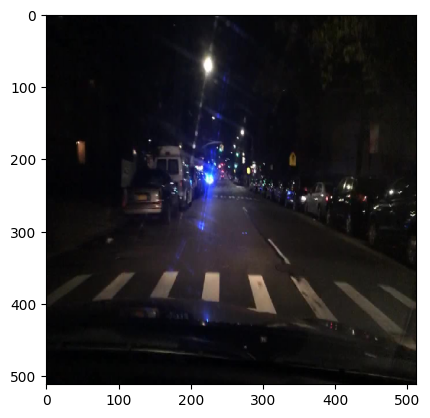

In [ ]:
plt.imshow((data_night_random[0]+1)/2)

# Load Weights (day2night)

In [ ]:
folder_name = 'train2_esrgan+_100epoch_oneID_day2night_10rrdrb'
main_path ='/content/gdrive/MyDrive/'+ folder_name +'/' + folder_name
epoch = 96
num_dataset = dataset_day2night[0].shape[0]

In [ ]:
# define input shape based on the loaded dataset
image_shape = dataset_day2night[0].shape[1:]
hr_shape = dataset_day2night[1].shape[1:]
target_shape = 2 #upscale on what factor
num_rrdrb = 10
beta = 0.01
gamma = 0.01
stddev = 0.01

# generator: A -> B
g_model_AtoB = define_generator(image_shape, n_resnet = 9) # Dari generator GXY' (LR -> CLR)
path_AtoB = main_path + '/g_model_AtoB_%06d.weights.h5' %(epoch*num_dataset)
g_model_AtoB.load_weights(path_AtoB)

# generator: B -> A
g_model_BtoA = define_generator(image_shape, n_resnet = 9) # Dari generator GY'X (CLR -> LR)
path_BtoA = main_path + '/g_model_BtoA_%06d.weights.h5' %(epoch*num_dataset)
g_model_BtoA.load_weights(path_BtoA)

# SR
sr_model_PtoSR = super_resolution2(image_shape, target_shape, num_rrdrb, beta, gamma, stddev)
path_SR = main_path + '/sr_model_%06d.weights.h5' %(epoch*num_dataset)
#path_SR = '/content/gdrive/MyDrive/test_unpairedSISR100epoch_esrgan+_train2_twoID/test_unpairedSISR100epoch_esrgan+_train2_twoID/sr_model_016900.weights.h5'
sr_model_PtoSR.load_weights(path_SR)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
day2night = g_model_AtoB.predict(preprocesed_data_test)
# nightSR = sr_model_PtoSR.predict(day2night)

1/1 [==============================] - 1s 759ms/step


1/1 [==============================] - 3s 3s/step


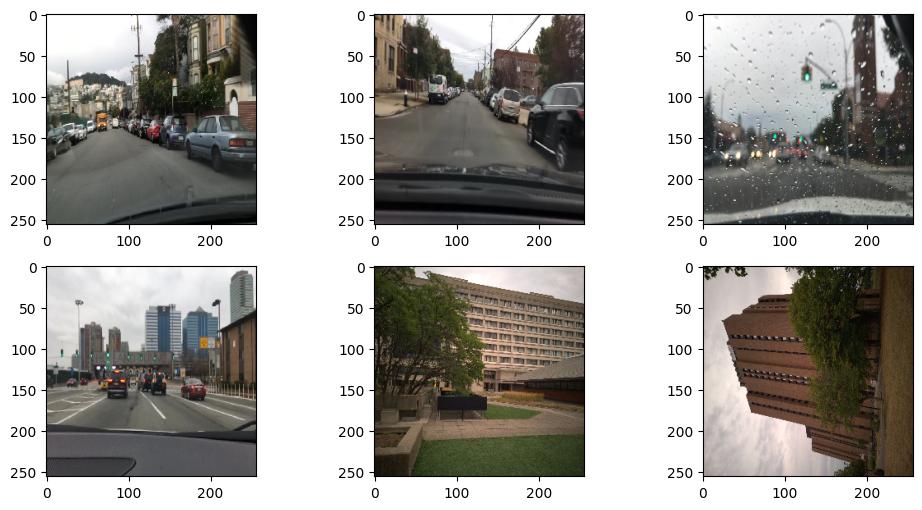

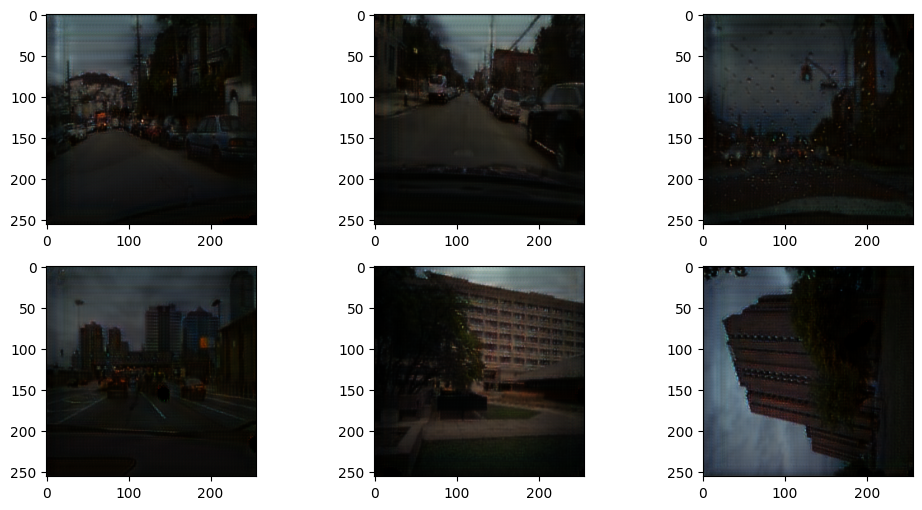

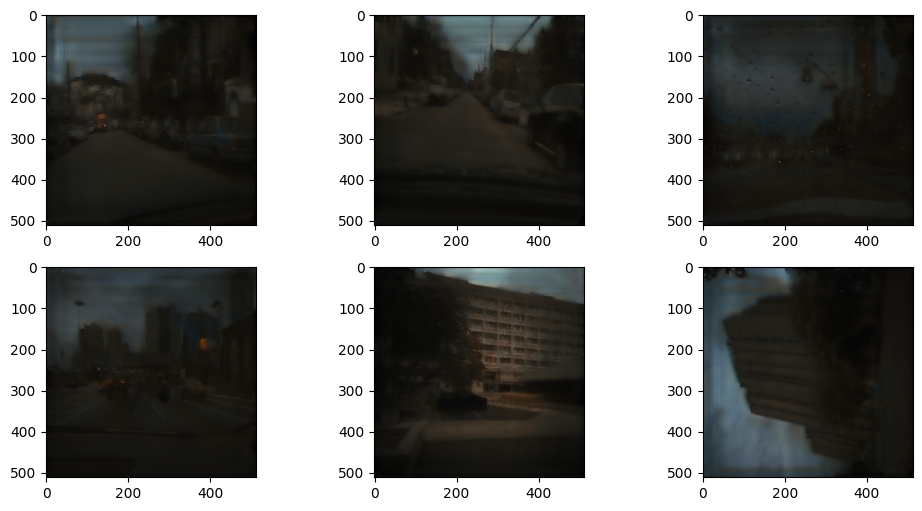

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow((preprocesed_data_test[i] + 1)/2)

#plt.savefig('day_input.png')

plt.figure(figsize=(12, 6))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow((day2night[i] + 1)/2)

plt.figure(figsize=(12, 6))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow((nightSR[i] + 1)/2)

In [ ]:
im_path_test = '/content/gdrive/MyDrive/image_visualization_SR/'
sample = 6
im = (nightSR[sample]+1) /2
im = cv2.cvtColor(im*255, cv2.COLOR_BGR2RGB)
cv2.imwrite(im_path_test + f'night_generated_unpairedSISR_ESRGAN+_{sample}.png',im)

IndexError: index 6 is out of bounds for axis 0 with size 6

In [ ]:
# sr_model_PtoSR = super_resolution(image_shape, target_shape, num_rrdrb, beta, gamma, stddev)
# #path_SR = main_path + '/sr_model_%06d.weights.h5' %(epoch*num_dataset)
# path_SR = '/content/gdrive/MyDrive/test_unpairedSISR100epoch_esrgan+_train2_twoID/test_unpairedSISR100epoch_esrgan+_train2_twoID/sr_model_016900.weights.h5'
# sr_model_PtoSR.load_weights(path_SR,by_name = True)

In [ ]:
day_dataset = dataset_day2night[0]
day_dataset.shape

(169, 256, 256, 3)

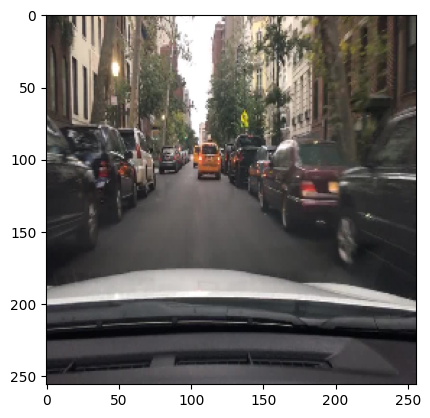

In [ ]:
plt.imshow((day_dataset[0]+1)/2.0)

In [ ]:
day2night = g_model_AtoB.predict(day_dataset)

6/6 [==============================] - 2s 173ms/step


In [ ]:
day2night = g_model_AtoB.predict(day_dataset)
im_sr_day2night = []
for image in day2night:
  image = image[np.newaxis,:,:,:]
  sr_day2night = sr_model_PtoSR.predict(image)
  im_sr_day2night.append(sr_day2night[0])

1/1 [==============================] - 0s 85ms/step


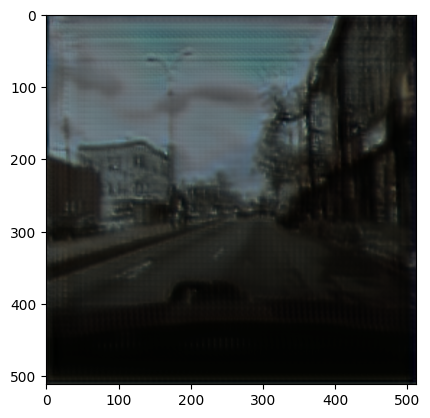

In [ ]:
im_sr_day2night = np.array(im_sr_day2night)
im_sr_day2night.shape
plt.imshow((im_sr_day2night[55]+1)/2.0)

In [ ]:
# day2night = (day2night + 1)/2.0
# day2night = day2night*255.0

# for num,i in enumerate(day2night):
#   image = cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
#   print(i.shape)
#   cv2.imwrite('/content/gdrive/MyDrive/day2night_unpairedSISR/' + str(num) + '.jpg', image)

In [ ]:
# path = '/content/gdrive/MyDrive/day2night_unpairedSISR/'

# # load all images in a directory into memory
# def load_images(path, size=(256,256)):
# 	data_list = list()
# 	# enumerate filenames in directory, assume all are images
# 	for filename in listdir(path):
# 		# load and resize the image
# 		pixels = load_img(path + filename, target_size=size)
# 		# convert to numpy array
# 		pixels = img_to_array(pixels)
# 		# store
# 		data_list.append(pixels)
# 	return asarray(data_list)

# def preprocess_data(data):
# 	# load compressed arrays
# 	# unpack arrays
# 	X1 = data
# 	# scale from [0,255] to [-1,1]
# 	X1 = (X1 - 127.5) / 127.5
# 	return X1

# day2night = load_images(path)
# day2night_prep = preprocess_data(day2night)

In [ ]:
# sampel = 100
# plt.imshow(day2night[sampel].astype(('uint8')))

In [ ]:
# day2night_prep[sampel][np.newaxis,:,:,:].shape

In [ ]:
# sr_day2night = sr_model_PtoSR.predict(day2night_prep[sampel][np.newaxis,:,:,:])

In [ ]:
# plt.imshow((sr_day2night[0]+1)/2.0)

In [ ]:
# im_sr_day2night = []
# for image in day2night_prep:
#   image = image[np.newaxis,:,:,:]
#   sr_day2night = sr_model_PtoSR.predict(image)
#   im_sr_day2night.append(sr_day2night[0])


In [ ]:
# im_sr_day2night = np.array(im_sr_day2night)
# im_sr_day2night.shape

In [ ]:
# plt.imshow((im_sr_day2night[43]+1)/2.0)

In [ ]:
# plt.figure(figsize=(12, 6))
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.imshow((preprocesed_data_test[i] + 1)/2)

# #plt.savefig('day_input.png')

# plt.figure(figsize=(12, 6))
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.imshow((day2night[i] + 1)/2)

# plt.figure(figsize=(12, 6))
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.imshow((sr_day2night[i] + 1)/2)

# plt.savefig('sr_day2night.png')

In [ ]:
# scale an array of images to a new size
def scale_images(images, new_shape):
  images_list = list()
  for image in images:
    # resize with nearest neighbor interpolation
    new_image = resize(image, new_shape, 0)
    # store
    images_list.append(new_image)
  return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
 # calculate activations
 act1 = model.predict(images1)
 act2 = model.predict(images2)
 # calculate mean and covariance statistics
 mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
 mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
 # calculate sum squared difference between means
 ssdiff = numpy.sum((mu1 - mu2)**2.0)
 # calculate sqrt of product between cov
 covmean = sqrtm(sigma1.dot(sigma2))
 # check and correct imaginary numbers from sqrt
 if iscomplexobj(covmean):
  covmean = covmean.real
 # calculate score
 fid = ssdiff + trace(sigma1) + trace(sigma2) - 2.0 * trace(covmean)
 return fid,act1,act2,sigma1,sigma2,covmean,ssdiff

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3), weights = 'imagenet', classifier_activation = None)
model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_1715 (Conv2D)        (None, 149, 149, 32)         864       ['input_22[0][0]']            
                                                                                                  
 batch_normalization_376 (B  (None, 149, 149, 32)         96        ['conv2d_1715[0][0]']         
 atchNormalization)                                                                               
                                                                                                  
 activation_576 (Activation  (None, 149, 149, 32)         0         ['batch_normalizati

In [ ]:
day_dataset_512 = dataset_day2night[1]

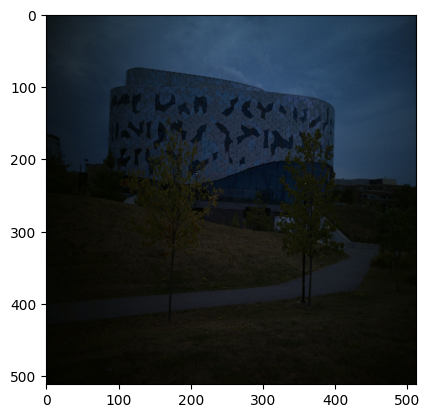

In [ ]:
plt.imshow((day_dataset_512[0]+1)/2.0)

In [ ]:
# Input Image
day_dataset_512 = (day_dataset_512 +1)/2.0
day_unnorm = day_dataset_512 * 255.0
day_unnorm_scaled = scale_images(day_unnorm, (299,299,3))
day_inception = preprocess_input(day_unnorm_scaled)

# Preprocess

# UVCGAN + Upsampling
im_sr_day2night_norm = (im_sr_day2night + 1)/2.0
im_sr_day2night_unnorm = im_sr_day2night_norm * 255.0
im_sr_day2night_unnorm_scaled = scale_images(im_sr_day2night_unnorm, (299,299,3))
im_sr_day2night_inception = preprocess_input(im_sr_day2night_unnorm_scaled)

# fid between images1 and images1
fid_s,act1_s,act2_s,sigma1_s,sigma2_s,covmean_s,ssdiff_s = calculate_fid(model, day_inception, day_inception)
print('FID (same): %.3f' % ssdiff_s)

# UVCGAN
fid_d_uvcgan,act1_d,act2_d,sigma1_d,sigma2_d,covmean_d,ssdiff_d_im_sr_day2night = calculate_fid(model, day_inception, im_sr_day2night_inception)
print('FID (same) - UVCGAN: %.3f' % ssdiff_d_im_sr_day2night)

6/6 [==============================] - 0s 27ms/step
FID (same): 0.000
6/6 [==============================] - 0s 23ms/step
FID (same) - UVCGAN: 57.552


In [ ]:
day_inception.shape, im_sr_day2night_inception.shape

((169, 299, 299, 3), (169, 299, 299, 3))

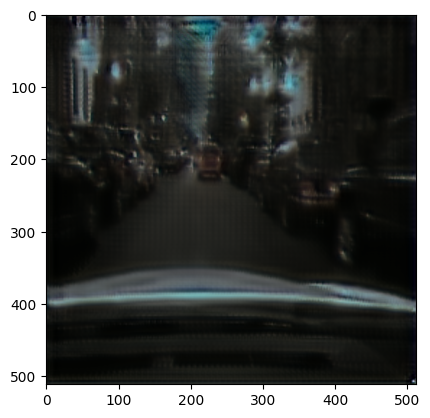

In [ ]:
plt.imshow(im_sr_day2night_norm[0])

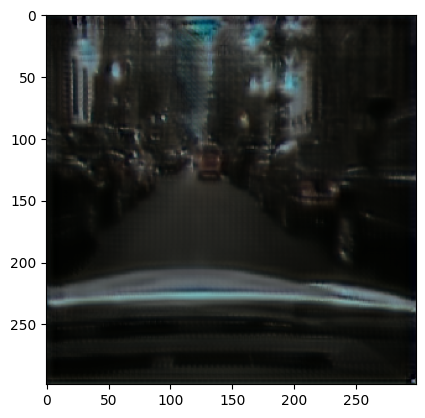

In [ ]:
plt.imshow((im_sr_day2night_inception[0]+1)/2.0)

In [ ]:
ssim_uvcgan_up = []
for day_real,night_gen in zip(day_dataset_512,im_sr_day2night_norm):
  im1 = color.rgb2gray(day_real)
  im2 = color.rgb2gray(night_gen)
  ssim_value = ssim(im1, im2, data_range = 1.0)
  ssim_uvcgan_up.append(ssim_value)

print(f'Average SSIM UVCGAN + Upsamling for {len(day)} images', sum(ssim_uvcgan_up)/len(ssim_uvcgan_up))

Average SSIM UVCGAN + Upsamling for 169 images 0.42987581655296747


# ALL EPOCH TEST DATA

In [ ]:
# scale an array of images to a new size
def scale_images(images, new_shape):
  images_list = list()
  for image in images:
    # resize with nearest neighbor interpolation
    new_image = resize(image, new_shape, 0)
    # store
    images_list.append(new_image)
  return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
 # calculate activations
 act1 = model.predict(images1)
 act2 = model.predict(images2)
 # calculate mean and covariance statistics
 mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
 mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
 # calculate sum squared difference between means
 ssdiff = numpy.sum((mu1 - mu2)**2.0)
 # calculate sqrt of product between cov
 covmean = sqrtm(sigma1.dot(sigma2))
 # check and correct imaginary numbers from sqrt
 if iscomplexobj(covmean):
  covmean = covmean.real
 # calculate score
 fid = ssdiff + trace(sigma1) + trace(sigma2) - 2.0 * trace(covmean)
 return fid,act1,act2,sigma1,sigma2,covmean,ssdiff

# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3), weights = 'imagenet', classifier_activation = None)
model.summary()

def calculate_fid_func(data_night,night_HRDisc):
  # Input Image
  day_dataset_512 = (data_night +1)/2.0
  day_unnorm = day_dataset_512 * 255.0
  day_unnorm_scaled = scale_images(day_unnorm, (299,299,3))
  day_inception = preprocess_input(day_unnorm_scaled)

  # Preprocess

  # UVCGAN + Upsampling
  night_generated_norm_HRDisc = (night_HRDisc + 1)/2.0
  night_generated_unnorm_HRDisc = night_generated_norm_HRDisc * 255.0
  night_generated_unnorm_scaled_HRDisc = scale_images(night_generated_unnorm_HRDisc, (299,299,3))
  night_generated_inception_HRDisc = preprocess_input(night_generated_unnorm_scaled_HRDisc)

  # fid between images1 and images1
  fid_s,act1_s,act2_s,sigma1_s,sigma2_s,covmean_s,ssdiff_s = calculate_fid(model, day_inception, day_inception)
  print('FID (same): %.3f' % ssdiff_s)

  # UVCGAN
  fid_d_uvcgan,act1_d,act2_d,sigma1_d,sigma2_d,covmean_d,ssdiff_d_HRDisc = calculate_fid(model, day_inception, night_generated_inception_HRDisc)
  #print('FID (same) - UVCGAN + Upsampling: %.3f' % ssdiff_d_HRDisc)

  return ssdiff_d_HRDisc

def calculate_ssim_func(data_night,night_HRDisc):
  # Input Image
  day_dataset_512 = (data_night + 1)/2.0

  # UVCGAN + Upsampling
  night_generated_norm_HRDisc = (night_HRDisc + 1)/2.0

  ssim_uvcgan_up = []
  for day_real,night_gen in zip(day_dataset_512,night_generated_norm_HRDisc):
    im1 = color.rgb2gray(day_real)
    im2 = color.rgb2gray(night_gen)
    ssim_value = ssim(im1, im2, data_range = 1.0)
    ssim_uvcgan_up.append(ssim_value)

  #print(f'Average SSIM UVCGAN + Upsamling for {len(day)} images', sum(ssim_uvcgan_up)/len(ssim_uvcgan_up))
  #print(f'Average SSIM UVCGAN + ESRGAN+ {len(day)} images', sum(ssim_uvcgan_esrgan)/len(ssim_uvcgan_esrgan))
  #print(f'Average SSIM UVCGAN + EnlightenGAN {len(day)} images', sum(ssim_uvcgan_enlighten)/len(ssim_uvcgan_enlighten))

  return sum(ssim_uvcgan_up)/len(ssim_uvcgan_up)


87910968/87910968 [==============================] - 5s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

(50, 256, 256, 3)


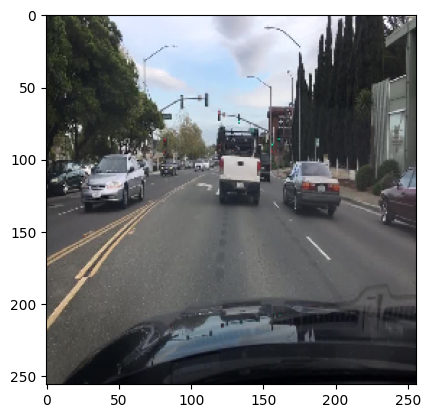

In [ ]:
day_dataset = data_test_random
print(day_dataset.shape)

plt.imshow((day_dataset[0]+1)/2.0)

In [ ]:
# Disable TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

In [ ]:
for epoch in range(88,102,2):
  # Disable TensorFlow logs
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  tf.get_logger().setLevel('ERROR')
  folder_name = 'train2_esrgan+_100epoch_oneID_day2night_10rrdrb'
  main_path ='/content/gdrive/MyDrive/'+ folder_name +'/' + folder_name
  #epoch = 90
  num_dataset = dataset_day2night[0].shape[0]

  # define input shape based on the loaded dataset
  image_shape = dataset_day2night[0].shape[1:]
  hr_shape = dataset_day2night[1].shape[1:]
  target_shape = 2 #upscale on what factor
  num_rrdrb = 10
  beta = 0.01
  gamma = 0.01
  stddev = 0.01

  # generator: A -> B
  g_model_AtoB = define_generator(image_shape, n_resnet = 9) # Dari generator GXY' (LR -> CLR)
  path_AtoB = main_path + '/g_model_AtoB_%06d.weights.h5' %(epoch*num_dataset)
  g_model_AtoB.load_weights(path_AtoB)

  # generator: B -> A
  g_model_BtoA = define_generator(image_shape, n_resnet = 9) # Dari generator GY'X (CLR -> LR)
  path_BtoA = main_path + '/g_model_BtoA_%06d.weights.h5' %(epoch*num_dataset)
  g_model_BtoA.load_weights(path_BtoA)

  # SR
  sr_model_PtoSR = super_resolution2(image_shape, target_shape, num_rrdrb, beta, gamma, stddev)
  path_SR = main_path + '/sr_model_%06d.weights.h5' %(epoch*num_dataset)
  #path_SR = '/content/gdrive/MyDrive/test_unpairedSISR100epoch_esrgan+_train2_twoID/test_unpairedSISR100epoch_esrgan+_train2_twoID/sr_model_016900.weights.h5'
  sr_model_PtoSR.load_weights(path_SR)

  day2night = g_model_AtoB.predict(data_test_random)

  im_sr_day2night = []
  for image in day2night:
    image = image[np.newaxis,:,:,:]
    sr_day2night = sr_model_PtoSR.predict(image)
    im_sr_day2night.append(sr_day2night[0])

  im_sr_day2night = np.array(im_sr_day2night)

  print(f'Epoch : {epoch}')
  ssdiff_d_HRDisc = calculate_fid_func(data_night_random,im_sr_day2night)
  print('FID - UnpairedSISR: %.3f' % ssdiff_d_HRDisc)

  ssim_upsam = calculate_ssim_func(data_night_random,im_sr_day2night)
  print(f'Average SSIM UnpairedSISR for {len(data_night_random)} images', ssim_upsam)

  print(' ')
  print(' ')
  print(' ')


1/1 [==============================] - 0s 87ms/step
Epoch : 88
2/2 [==============================] - 0s 25ms/step
FID (same): 0.000
2/2 [==============================] - 0s 25ms/step
FID - UnpairedSISR: 54.873
Average SSIM UnpairedSISR for 50 images 0.4254323091448215
 
 
 


1/1 [==============================] - 0s 85ms/step
Epoch : 90
2/2 [==============================] - 0s 26ms/step
FID (same): 0.000
2/2 [==============================] - 0s 25ms/step
FID - UnpairedSISR: 97.584
Average SSIM UnpairedSISR for 50 images 0.37767587062002944
 
 
 


1/1 [==============================] - 0s 86ms/step
Epoch : 92
2/2 [==============================] - 0s 25ms/step
FID (same): 0.000
2/2 [==============================] - 0s 25ms/step
FID - UnpairedSISR: 61.374
Average SSIM UnpairedSISR for 50 images 0.43967078408770244
 
 
 


1/1 [==============================] - 0s 86ms/step
Epoch : 94
2/2 [==============================] - 0s 25ms/step
FID (same): 0.000
2/2 [==============================] - 0s 25ms/step
FID - UnpairedSISR: 69.325
Average SSIM UnpairedSISR for 50 images 0.4686613216157716
 
 
 


1/1 [==============================] - 0s 88ms/step
Epoch : 96
2/2 [==============================] - 0s 21ms/step
FID (same): 0.000
2/2 [==============================] - 0s 25ms/step
FID - UnpairedSISR: 75.452
Average SSIM UnpairedSISR for 50 images 0.4820459501979207
 
 
 


1/1 [==============================] - 0s 86ms/step
Epoch : 98
2/2 [==============================] - 0s 25ms/step
FID (same): 0.000
2/2 [==============================] - 0s 25ms/step
FID - UnpairedSISR: 64.335
Average SSIM UnpairedSISR for 50 images 0.4671914301836633
 
 
 


1/1 [==============================] - 0s 91ms/step
Epoch : 100
2/2 [==============================] - 0s 25ms/step
FID (same): 0.000
2/2 [==============================] - 0s 25ms/step
FID - UnpairedSISR: 78.518
Average SSIM UnpairedSISR for 50 images 0.49227217805994444
 
 
 



Epoch : 88
2/2 [==============================] - 0s 21ms/step
2/2 [==============================] - 0s 25ms/step
FID (same): 0.000
2/2 [==============================] - 0s 25ms/step
2/2 [==============================] - 0s 25ms/step
FID - UnpairedSISR: 54.873
Average SSIM UnpairedSISR for 50 images 0.4254323091448215


Epoch : 90
2/2 [==============================] - 0s 21ms/step
2/2 [==============================] - 0s 26ms/step
FID (same): 0.000
2/2 [==============================] - 0s 25ms/step
2/2 [==============================] - 0s 25ms/step
FID - UnpairedSISR: 97.584
Average SSIM UnpairedSISR for 50 images 0.37767587062002944


Epoch : 92
2/2 [==============================] - 0s 21ms/step
2/2 [==============================] - 0s 25ms/step
FID (same): 0.000
2/2 [==============================] - 0s 25ms/step
2/2 [==============================] - 0s 25ms/step
FID - UnpairedSISR: 61.374
Average SSIM UnpairedSISR for 50 images 0.43967078408770244


Epoch : 94
2/2 [==============================] - 0s 21ms/step
2/2 [==============================] - 0s 25ms/step
FID (same): 0.000
2/2 [==============================] - 0s 25ms/step
2/2 [==============================] - 0s 25ms/step
FID - UnpairedSISR: 69.325
Average SSIM UnpairedSISR for 50 images 0.4686613216157716


Epoch : 96
2/2 [==============================] - 0s 22ms/step
2/2 [==============================] - 0s 21ms/step
FID (same): 0.000
2/2 [==============================] - 0s 24ms/step
2/2 [==============================] - 0s 25ms/step
FID - UnpairedSISR: 75.452
Average SSIM UnpairedSISR for 50 images 0.4820459501979207


Epoch : 98
2/2 [==============================] - 0s 21ms/step
2/2 [==============================] - 0s 25ms/step
FID (same): 0.000
2/2 [==============================] - 0s 25ms/step
2/2 [==============================] - 0s 25ms/step
FID - UnpairedSISR: 64.335
Average SSIM UnpairedSISR for 50 images 0.4671914301836633



Epoch : 100
2/2 [==============================] - 0s 21ms/step
2/2 [==============================] - 0s 25ms/step
FID (same): 0.000
2/2 [==============================] - 0s 27ms/step
2/2 [==============================] - 0s 25ms/step
FID - UnpairedSISR: 78.518
Average SSIM UnpairedSISR for 50 images 0.49227217805994444

# KESIMPULAN EVALUASI UNPAIRED SISR


## **Data Train**

**FID**

**Kesimpulan** : Ambil epoch 90

* FID (same) - UnpairedSISR: **57.552**

**SSIM**

**Kesimpulan** : Ambil epoch 90

*   Average SSIM UnpairedSISR for 169 images **0.42987581655296747**

## **Data Test**

**FID**

**Kesimpulan** : Ambil epoch 94

*   FID - UnpairedSISR: **69.325**

**SSIM**

**Kesimpulan** : Ambil epoch 90

*  Average SSIM UnpairedSISR for 50 images **0.37767587062002944**

# generate data for yolo (UNet-ViT + ESRGAN+)

In [ ]:
# load all images in a directory into memory
def load_images_nfilename(path, size=(256,256)):
	data_list = list()
	data_list512 = list()
	file_name = []
	# enumerate filenames in directory, assume all are images
	for filename in os.listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		pixels512 = load_img(path + filename, target_size=(512,512))
		# convert to numpy array
		pixels = img_to_array(pixels)
		pixels512 = img_to_array(pixels512)
		# store
		data_list.append(pixels)
		data_list512.append(pixels512)
		file_name.append(filename)
	return asarray(data_list), asarray(data_list512), file_name

# dataset path
path = '/content/day2night/'

# load dataset A - day
day_data,day_data_512,file_name = load_images_nfilename(path + 'trainDay/')
print('Loaded data_day: ', day_data.shape)
print('Loeaded data_dat_512: ', day_data_512.shape)

Loaded data_day:  (169, 256, 256, 3)
Loeaded data_dat_512:  (169, 512, 512, 3)


1cbc711c-205586b2.jpg


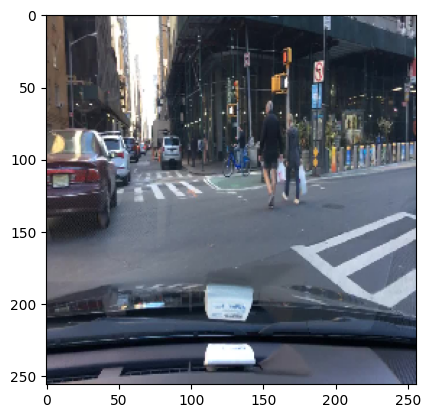

In [ ]:
sampel = 23
print(file_name[sampel])
plt.imshow(day_data[sampel].astype('uint8'))

1cbc711c-205586b2.jpg


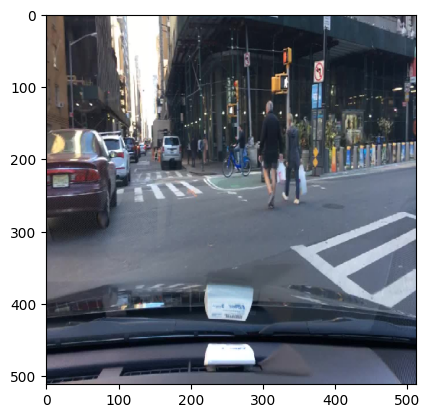

In [ ]:
print(file_name[sampel])
plt.imshow(day_data_512[sampel].astype('uint8'))

In [ ]:
def preprocess_day_data(data):
	# load compressed arrays
	# unpack arrays
	X1 = data
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	return X1

data_day_preprocessed = preprocess_day_data(day_data)
data_day_preprocessed_512 = preprocess_day_data(day_data_512)

In [ ]:
data_day_preprocessed.shape,  data_day_preprocessed_512.shape

((169, 256, 256, 3), (169, 512, 512, 3))

In [ ]:
#_,night_data= g_model_AtoB.predict(data_day_preprocessed)
day2night = g_model_AtoB.predict(data_day_preprocessed)
im_sr_day2night = []
for image in day2night:
  image = image[np.newaxis,:,:,:]
  sr_day2night = sr_model_PtoSR.predict(image)
  im_sr_day2night.append(sr_day2night[0])

1/1 [==============================] - 0s 86ms/step


In [ ]:
im_sr_day2night = np.array(im_sr_day2night)

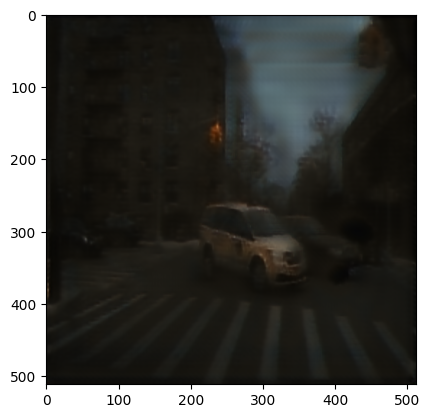

In [ ]:
plt.imshow((im_sr_day2night[78]+1)/2)

In [ ]:
file_name_night = []
for filename in file_name:
  file_name_night.append(filename[:-4]+'_night512.jpg')

In [ ]:
im_sr_day2night.shape

(169, 512, 512, 3)

In [ ]:
day = (data_day_preprocessed+1)/2
day512 = (data_day_preprocessed_512+1)/2
night512 = (im_sr_day2night+1)/2

In [ ]:
path_gen_image = '/content/gdrive/MyDrive/unpairedSISR_yolo/images/'
path_gen_label = '/content/gdrive/MyDrive/unpairedSISR_yolo/labels/'

def save_generated_images(day512,night512,filename_day,new_path):

  filename_night = []
  for filename in filename_day:
    filename_night.append(filename[:-4]+'_night512.jpg')

  path_gen = '/content/gdrive/MyDrive/' + new_path + '/'

  # Check if the directory exists
  if not os.path.exists(path_gen):
    os.mkdir(path_gen)
  else:
    print(f"Directory '{path_gen}' already exists.")

  path_gen_image = '/content/gdrive/MyDrive/' + new_path + '/images/'

  # Check if the directory exists
  if not os.path.exists(path_gen_image):
    os.mkdir(path_gen_image)
  else:
    print(f"Directory '{path_gen_image}' already exists.")

  path_gen_label = '/content/gdrive/MyDrive/' + new_path + '/labels/'

  # Check if the directory exists
  if not os.path.exists(path_gen_label):
    os.mkdir(path_gen_label)
  else:
    print(f"Directory '{path_gen_label}' already exists.")

  for d,fd,n,fn in zip(day512,filename_day,night512,filename_night):
    #day
    im_day = cv2.cvtColor(d*255,cv2.COLOR_BGR2RGB)
    cv2.imwrite(path_gen_image + fd, im_day)
    print(path_gen_image + fd)
    #night
    im_night = cv2.cvtColor(n*255,cv2.COLOR_BGR2RGB)
    cv2.imwrite(path_gen_image + fn, im_night)
    print(path_gen_image + fn)

In [ ]:
save_generated_images(day512,night512,file_name,'unpairedSISR_yolo')

/content/gdrive/MyDrive/unpairedSISR_yolo/images/1c1de1e7-346d6219.jpg
/content/gdrive/MyDrive/unpairedSISR_yolo/images/1c1de1e7-346d6219_night512.jpg
/content/gdrive/MyDrive/unpairedSISR_yolo/images/Image_56.jpg
/content/gdrive/MyDrive/unpairedSISR_yolo/images/Image_56_night512.jpg
/content/gdrive/MyDrive/unpairedSISR_yolo/images/Image_25.jpg
/content/gdrive/MyDrive/unpairedSISR_yolo/images/Image_25_night512.jpg
/content/gdrive/MyDrive/unpairedSISR_yolo/images/00f7eac8-5193d600.jpg
/content/gdrive/MyDrive/unpairedSISR_yolo/images/00f7eac8-5193d600_night512.jpg
/content/gdrive/MyDrive/unpairedSISR_yolo/images/0dc3d787-4982a6e6.jpg
/content/gdrive/MyDrive/unpairedSISR_yolo/images/0dc3d787-4982a6e6_night512.jpg
/content/gdrive/MyDrive/unpairedSISR_yolo/images/Image_57.jpg
/content/gdrive/MyDrive/unpairedSISR_yolo/images/Image_57_night512.jpg
/content/gdrive/MyDrive/unpairedSISR_yolo/images/4cd91231-65fa72bd.jpg
/content/gdrive/MyDrive/unpairedSISR_yolo/images/4cd91231-65fa72bd_night512.j

(512, 512, 3)


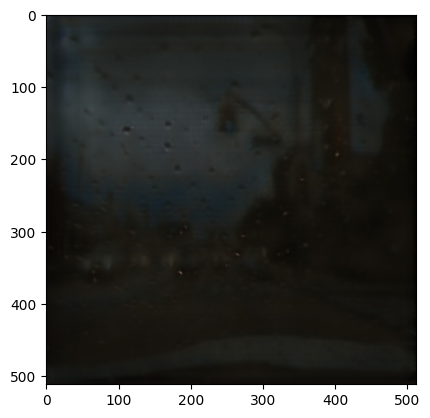

In [ ]:
a = cv2.imread('/content/gdrive/MyDrive/unpairedSISR_yolo/images/0f9fbe4b-081bb395_night512.jpg')
a = cv2.cvtColor(a,cv2.COLOR_BGR2RGB)
print(a.shape)
plt.imshow(a)

# generate data for yolo

In [ ]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

In [ ]:
# Save generated image on

def create_path(day_im,night_im,new_path):
  path_gen = '/content/gdrive/MyDrive/' + new_path + '/'

  # Check if the directory exists
  if not os.path.exists(path_gen):
    os.mkdir(path_gen)
  else:
    print(f"Directory '{path_gen}' already exists.")

  path_gen_day = '/content/gdrive/MyDrive/' + new_path + '/day/'

  # Check if the directory exists
  if not os.path.exists(path_gen_day):
    os.mkdir(path_gen_day)
  else:
    print(f"Directory '{path_gen_day}' already exists.")

  path_gen_night = '/content/gdrive/MyDrive/' + new_path + '/night/'

  # Check if the directory exists
  if not os.path.exists(path_gen_night):
    os.mkdir(path_gen_night)
  else:
    print(f"Directory '{path_gen_night}' already exists.")

  # UNNORMALIZED IMAGE IS SAVED WITH THE RANGE OF [0,255]
  for i in range(len(day_im)):
    #day
    im_day = cv2.cvtColor(day_im[i]*255,cv2.COLOR_BGR2RGB)
    cv2.imwrite(path_gen_day + str(i) + '.jpg', im_day)

    #night
    im_night = cv2.cvtColor(night_im[i]*255,cv2.COLOR_BGR2RGB)
    cv2.imwrite(path_gen_night + str(i) + '.jpg', im_night)

create_path(day,night_generated_uvcgan,'night_generated_uvcgan')
create_path(day,night_generated_fpncgan,'night_generated_fpncgan')
create_path(day,night_generated_vcgan,'night_generated_vcgan')
create_path(day,night_generated_uvcgan_edgeloss,'night_generated_uvcgan_edgeloss')

# CREATE DATA TEST for visualization (synthetic2real)



In [ ]:
main_path = '/content/gdrive/MyDrive/night_generated_uvcgan/night/'
test_path = ['88.jpg','47.jpg','130.jpg','19.jpg','1.jpg','150.jpg']

In [ ]:
# load all images in a directory into memory
def load_images_test(path, test_im, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in test_im:
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

def preprocess_data_test(data):
	# load compressed arrays
	# unpack arrays
	# scale from [0,255] to [-1,1]
	X1 = (data - 127.5) / 127.5
	return X1

In [ ]:
# load dataset A - day
data_test = load_images_test(main_path, test_path)
print('Loaded data test: ', data_test.shape)

Loaded data test:  (6, 256, 256, 3)


In [ ]:
preprocesed_data_test_syn2real = preprocess_data_test(data_test)

# Load Weights (synthetic2real)

In [ ]:
folder_name = 'train2_esrgan+_100epoch_twoID_synthetic2real_10rrdrb'
main_path ='/content/gdrive/MyDrive/'+ folder_name +'/' + folder_name
epoch = 95
num_dataset = dataset[0].shape[0]

In [ ]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
hr_shape = dataset[1].shape[1:]
target_shape = 2 #upscale on what factor
num_rrdrb = 10
beta = 0.01
gamma = 0.01
stddev = 0.01

# generator: A -> B
g_model_AtoB = define_generator(image_shape, n_resnet = 9) # Dari generator GXY' (LR -> CLR)
path_AtoB = main_path + '/g_model_AtoB_%06d.weights.h5' %(epoch*num_dataset)
g_model_AtoB.load_weights(path_AtoB)

# generator: B -> A
g_model_BtoA = define_generator(image_shape, n_resnet = 9) # Dari generator GY'X (CLR -> LR)
path_BtoA = main_path + '/g_model_BtoA_%06d.weights.h5' %(epoch*num_dataset)
g_model_BtoA.load_weights(path_BtoA)

# SR
sr_model_PtoSR = super_resolution2(image_shape, target_shape, num_rrdrb, beta, gamma, stddev)
path_SR = main_path + '/sr_model_%06d.weights.h5' %(epoch*num_dataset)
#path_SR = '/content/gdrive/MyDrive/test_unpairedSISR100epoch_esrgan+_train2_twoID/test_unpairedSISR100epoch_esrgan+_train2_twoID/sr_model_016900.weights.h5'
sr_model_PtoSR.load_weights(path_SR)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# sr_model_PtoSR = super_resolution(image_shape, target_shape, num_rrdrb, beta, gamma, stddev)
# #path_SR = main_path + '/sr_model_%06d.weights.h5' %(epoch*num_dataset)
# path_SR = '/content/gdrive/MyDrive/test_unpairedSISR100epoch_esrgan+_train2_twoID/test_unpairedSISR100epoch_esrgan+_train2_twoID/sr_model_016900.weights.h5'
# sr_model_PtoSR.load_weights(path_SR,by_name = True)

In [ ]:
syn2real = g_model_AtoB.predict(preprocesed_data_test_syn2real)

1/1 [==============================] - 1s 844ms/step


In [ ]:
sr_syn2real = sr_model_PtoSR.predict(syn2real)

1/1 [==============================] - 0s 417ms/step


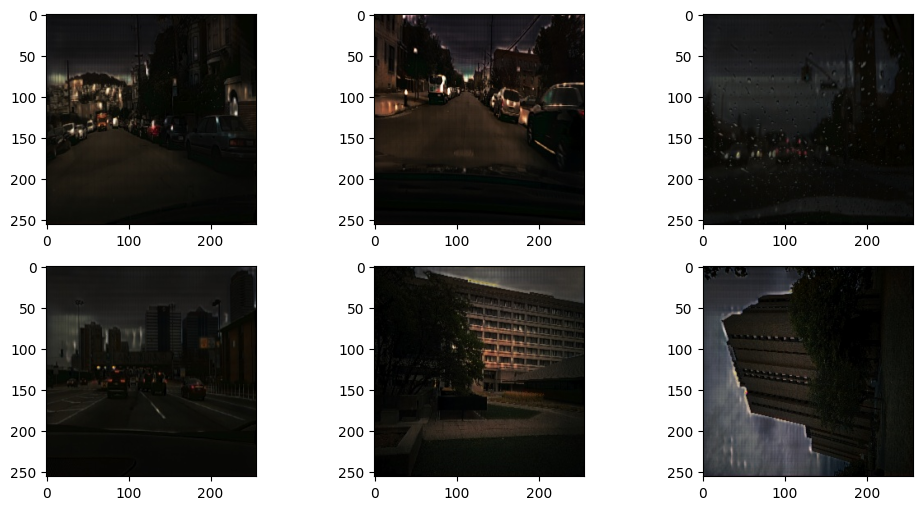

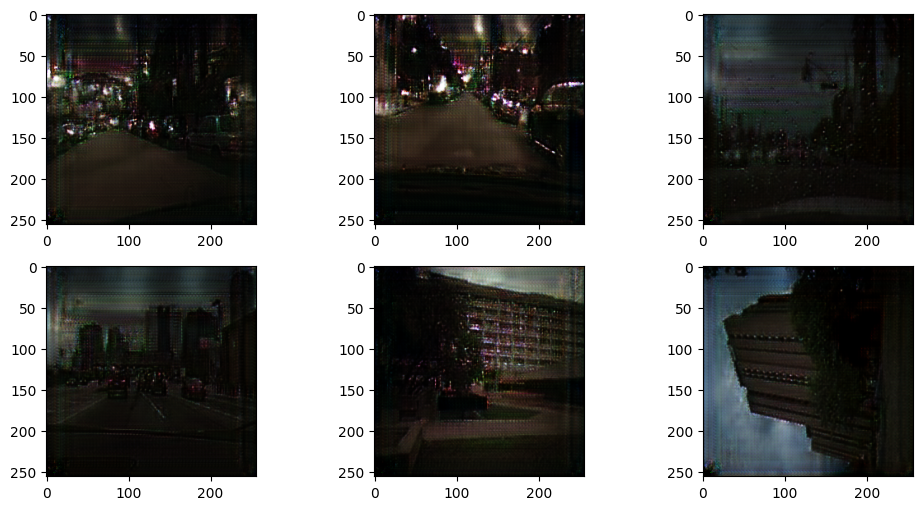

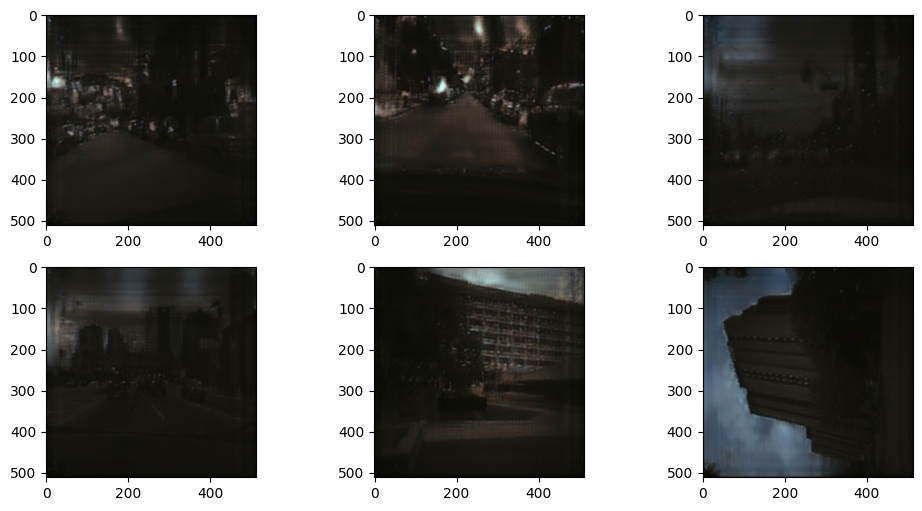

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow((preprocesed_data_test_syn2real[i] + 1)/2)

plt.savefig('syn2real_input.png')

plt.figure(figsize=(12, 6))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow((syn2real[i] + 1)/2)

plt.figure(figsize=(12, 6))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow((sr_syn2real[i] + 1)/2)

plt.savefig('sr_syn2real.png')